# Fairness in ML

![Brief History of Fairness in ML, source: https://blog.godatadriven.com/images/fairness-in-ml/fairness_plot.svg](brief_history.svg)

## Data can reflect social bias
Examples:
- [Amazon hiring tool](https://www.theguardian.com/technology/2018/oct/10/amazon-hiring-ai-gender-bias-recruiting-engine)
- [Google Translation of Turkish gender-neutral pronoun](https://qz.com/1141122/google-translates-gender-bias-pairs-he-with-hardworking-and-she-with-lazy-and-other-examples/))

## Awareness and correction is necessary
Especially in the following domains:
- Hiring
- Text translation
- Predictive policing
- Recidivism prediction

## COMPAS dataset: 
- aims to predict recidivism (Rückfälligkeit) based on criminal records
- features used here: sex, age category, charge degree, priors count, race
- protected attribute: race
- target: decile score $<$ 6: 0, decile score $\geq$ 6: 1

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, linear_model, metrics, svm
import numpy as np

In [2]:
data_orig = pd.read_csv("compas-analysis-master/compas-scores.csv")
display(data_orig.head())
print(data_orig.columns)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date'],
      dtype='object')


In [3]:
races = set(data_orig.race.values)
for race in races:
    print(race, round(len(data_orig[data_orig.race == race])/len(data_orig) * 100, 2))

Native American 0.34
African-American 49.44
Hispanic 9.36
Other 5.62
Caucasian 34.75
Asian 0.49


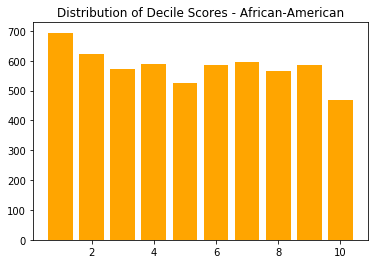

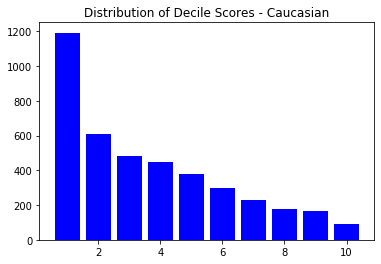

In [4]:
decile_scores_black = []
decile_scores_white = []
decile_scores_hispanic = []
for i in range(1, 11):
    decile_scores_black.append(len(data_orig.loc[(data_orig.race == 'African-American') & (data_orig.decile_score == i)]))
    decile_scores_white.append(len(data_orig.loc[(data_orig.race == 'Caucasian') & (data_orig.decile_score == i)]))
    decile_scores_hispanic.append(len(data_orig.loc[(data_orig.race == 'Hispanic') & (data_orig.decile_score == i)]))

plt.bar(range(1, 11), decile_scores_black, color='orange')
plt.title('Distribution of Decile Scores - African-American')
plt.show()
plt.bar(range(1, 11), decile_scores_white, color='blue')
plt.title('Distribution of Decile Scores - Caucasian')
plt.show()

In [5]:
def score_to_label(score_text):
    if score_text == 'Low':
        return 0
    elif score_text == 'Medium':
        return 1
    else:
        return 2

data = data_orig[['sex', 'age_cat', 'c_charge_degree', 'priors_count', 'score_text']]
data = data.dropna()
data['score_text'] = data['score_text'].map(score_to_label)
data_one_hot = pd.get_dummies(data.drop(['priors_count', 'score_text'], axis=1))
data_one_hot['priors_count'] = data['priors_count']
data_one_hot['score'] = data_orig['decile_score'] > 6
data_one_hot['score'] = data_one_hot['score'].apply(int)
display(data_one_hot.head())
x = data_one_hot.drop('score', axis=1)
y = data_one_hot['score']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42)

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,c_charge_degree_O,priors_count,score
0,0,1,0,1,0,1,0,0,0,0
1,0,1,1,0,0,0,0,1,0,0
2,0,1,1,0,0,1,0,0,0,0
3,0,1,0,0,1,1,0,0,4,0
4,0,1,0,0,1,1,0,0,1,1


## Fairness metrics:
- Demographic parity: classifier is fair if the rate at which we predict y is the same across states of the protected attribute
- Equalized odds: classifier is fair if all groups have equal false positive (FP/(FP+TN)) and false negative rates (FN/(TP+FN))
- Brier score: mean squared difference between the actual outcome and the predicted probability is the same for all groups (lower Brier score $\rightarrow$ better calibration)

In [6]:
fp_rates = {'Caucasian': -1, 'African-American': -1, 'Hispanic': -1}
fn_rates = {'Caucasian': -1, 'African-American': -1, 'Hispanic': -1}
predicted_positive_rates = {'Caucasian': -1, 'African-American': -1, 'Hispanic': -1}
losses = {'Caucasian': -1, 'African-American': -1, 'Hispanic': -1}
lr = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=250)
lr.fit(np.array(x_train), y_train)
y_pred = lr.predict(x_test)
score = lr.score(x_test, y_test)
y_prob = [elem [1] for elem in lr.predict_proba(x_test)]
y_pred_df = pd.DataFrame(y_pred)
y_prob_df = pd.DataFrame(y_prob)
for race in ['Caucasian', 'African-American', 'Hispanic']:
    x_test_new  = x_test.copy()
    x_test_new['race'] = data_orig.iloc[x_test_new.index, :]['race']
    x_test_new['new_index'] = range(0, len(x_test_new))
    race_indices = x_test_new.index[x_test_new['race'] == race].tolist()
    race_indices_loc = x_test_new.new_index[x_test_new['race'] == race].tolist()
    y_test_race = y_test[y_test.index.isin(race_indices)]
    y_pred_race = y_pred_df[y_pred_df.index.isin(race_indices_loc)]
    y_prob_race = y_prob_df[y_prob_df.index.isin(race_indices_loc)]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test_race, y_pred_race).ravel()
    losses[race] = metrics.brier_score_loss(y_test_race, y_prob_race)
    fp_rates[race] = fp / (fp + tn)
    fn_rates[race] = fn / (tp + fn)
    predicted_positive_rates[race] = list(y_pred_race.iloc[:, 0]).count(1) / len(y_pred_race)

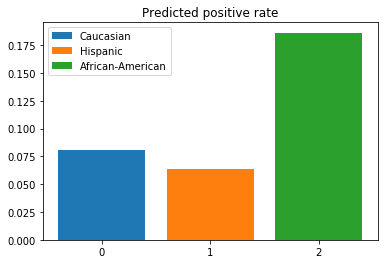

In [7]:
plt.bar(0, predicted_positive_rates['Caucasian'], label='Caucasian')
plt.bar(1, predicted_positive_rates['Hispanic'], label='Hispanic')
plt.bar(2, predicted_positive_rates['African-American'], label='African-American')
plt.xticks([0, 1, 2])
plt.legend()
plt.title('Predicted positive rate')
plt.show()

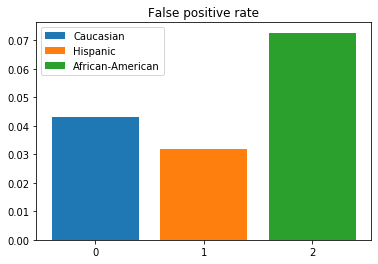

In [8]:
plt.bar(0, fp_rates['Caucasian'], label='Caucasian')
plt.bar(1, fp_rates['Hispanic'], label='Hispanic')
plt.bar(2, fp_rates['African-American'], label='African-American')
plt.xticks([0, 1, 2])
plt.legend()
plt.title('False positive rate')
plt.show()

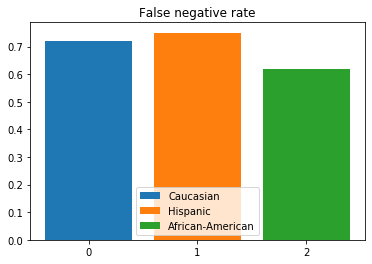

In [9]:
plt.bar(0, fn_rates['Caucasian'], label='Caucasian')
plt.bar(1, fn_rates['Hispanic'], label='Hispanic')
plt.bar(2, fn_rates['African-American'], label='African-American')
plt.xticks([0, 1, 2])
plt.legend()
plt.title('False negative rate')
plt.show()

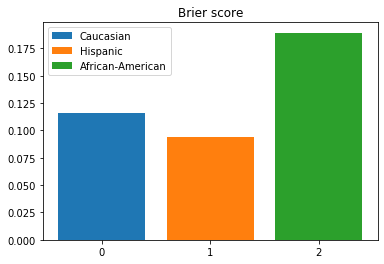

In [10]:
plt.bar(0, losses['Caucasian'], label='Caucasian')
plt.bar(1, losses['Hispanic'], label='Hispanic')
plt.bar(2, losses['African-American'], label='African-American')
plt.xticks([0, 1, 2])
plt.legend()
plt.title('Brier score')
plt.show()

## Approaches to counteract dicrimination in classifiers:
- counterfactual fairness: asking what would have happened if an individual's protected attribute was different
- positive counterfactuals: system gives individuals recommendations for the future by telling them what features they would need to change to be classified differently
- use more data, especially representing the groups which are discriminated against